# Sentiment Analysis with IMDB dataset
## Resources
- ...
- https://www.tensorflow.org/tutorials/keras/text_classification_with_hub 
- 핸즈온머신러닝2 16.2~ https://github.com/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb

In [1]:
# movie review text classification
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# # !pip3 install tensorflow_hub tensorflow_datasets matplotlib
# # ! clear
# print("Version: ", tf.__version__)
# print("Eager mode: ", tf.executing_eagerly())
# print("Hub version: ", hub.__version__)
# print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2022-09-15 01:33:05.970815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 01:33:05.970890: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load imdb_reviews data with tfds
train_data, test_data = tfds.load(name="imdb_reviews",
                        split=["train","test"], batch_size=-1,
                        as_supervised=True,
                        data_dir="./data/imdb_reviews",download=True);

2022-09-15 01:33:10.311446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-15 01:33:10.311568: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-15 01:33:10.311601: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HJ-ThinkPadX1C8): /proc/driver/nvidia/version does not exist
2022-09-15 01:33:10.312206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# split dataset as train, test, val
train_x, train_y = tfds.as_numpy(train_data)
test_x, test_y = tfds.as_numpy(test_data)

val_x, val_y = train_x[:10000], train_y[:10000]
train_x, train_y = train_x[10000:], train_y[10000:]

print(len(train_x), len(train_y),
    len(test_x), len(test_y),
    len(val_x), len(val_y))

# sample
for i in [1,2,100,200]:
    print(train_x[i][:30], train_y[i]) # label == 0 neg, 1 pos

15000 15000 25000 25000 10000 10000
b'There are many illnesses born ' 1
b'(originally a response to a mo' 1
b'A short review but...<br /><br' 0
b'Illudere (to delude) comes fro' 1


In [4]:
# create keras model with ...
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], 
    dtype=tf.string, trainable=True)
# hub_layer(train_x[:1])

In [5]:
# full model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer="adam",
    # used for binary classification model
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name="accuracy")])

In [7]:
history = model.fit(
    train_x, train_y, epochs=10, batch_size=512,
    validation_data = (val_x, val_y), verbose=1
)
results = model.evaluate(test_x, test_y) 
print(results) # loss, accuracy

Epoch 1/10
30/30 [==============================] - 25s 821ms/step - loss: 0.6710 - accuracy: 0.5961 - val_loss: 0.6106 - val_accuracy: 0.7106
Epoch 2/10
30/30 [==============================] - 27s 910ms/step - loss: 0.5383 - accuracy: 0.7727 - val_loss: 0.4927 - val_accuracy: 0.7960
Epoch 3/10
30/30 [==============================] - 20s 691ms/step - loss: 0.3999 - accuracy: 0.8560 - val_loss: 0.3983 - val_accuracy: 0.8362
Epoch 4/10
30/30 [==============================] - 18s 594ms/step - loss: 0.2896 - accuracy: 0.9027 - val_loss: 0.3427 - val_accuracy: 0.8564
Epoch 5/10
30/30 [==============================] - 18s 616ms/step - loss: 0.2141 - accuracy: 0.9318 - val_loss: 0.3157 - val_accuracy: 0.8668
Epoch 6/10
30/30 [==============================] - 17s 564ms/step - loss: 0.1591 - accuracy: 0.9537 - val_loss: 0.3053 - val_accuracy: 0.8723
Epoch 7/10
30/30 [==============================] - 17s 565ms/step - loss: 0.1167 - accuracy: 0.9714 - val_loss: 0.3019 - val_accuracy: 0.8721

In [8]:
hist_dict = history.history
# training acc, loss
acc = hist_dict["accuracy"]
loss = hist_dict["loss"]
# validation acc, loss
val_acc = hist_dict["val_loss"]
val_loss = hist_dict["val_accuracy"]

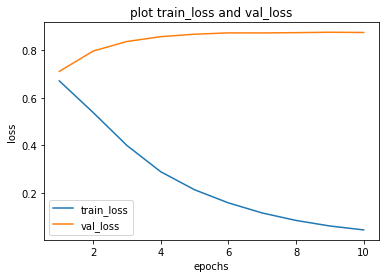

In [9]:
# plot loss graph
epochs = range(1,len(acc)+1)
plt.title("plot train_loss and val_loss")
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()
# loss decreases with each epoch, acc increases
# val loss, acc shows overfitting after ~20 epochs

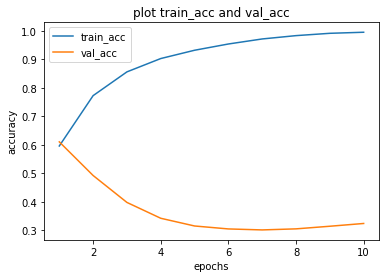

In [10]:
# plot accuracy graph
epochs = range(1,len(acc)+1)
plt.title("plot train_acc and val_acc")
plt.plot(epochs, acc, label="train_acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [20]:
x = [
    # good?
    b"good movie",
    b"best movie i've watched in my life",
    b"i will recommend this to my failiy",
    # bad?
    b"my mom hates this",
    b"will never watch this again",#??????
    b"disgusting",
    b"horrible movie",
]
y = model.predict(x)
print(y)

1/1 [==============================] - 0s 143ms/step
[[ 2.0474932]
 [ 3.1993828]
 [ 2.365034 ]
 [-1.1740134]
 [ 2.5816417]
 [-3.0705776]
 [-3.211593 ]]
